# Contig Length Distribution Analysis and Fitting

## Overview
This notebook analyzes the length distribution of contigs from filtered non-cellular sequences (output from [`1_contigs_overview_filter_make_fasta.ipynb`](../../contigs_report/1_contigs_overview_filter_make_fasta.ipynb)) and fits a mathematical curve to model this distribution. The fitted curve is then used for weighted sampling of reference genomes to maintain realistic length distributions in our training data.

## Workflow
1. **Data Loading**: Import filtered contigs and extract length information
2. **Distribution Fitting**: Fit an exponential + linear function to the length distribution
3. **Validation**: Compare original distribution with sampled reference contigs
4. **Export**: Save fitted parameters for downstream sampling processes

## Key Outputs
- Fitted curve parameters for contig length sampling
- Visualization of distribution fits
- Quality assessment of sampling results

In [2]:
import sys
sys.path.append('../scripts')
from utils import *

## 2. Data Loading and Preparation

Load the filtered contig sequences and extract length information for distribution analysis.

In [3]:
# Load filtered contigs from FASTA file
# These are non-cellular contigs that have been pre-filtered by the Snakemake pipeline
print("Loading filtered contigs...")
snakemake_contigs = SeqIO.to_dict(SeqIO.parse('../../data/contigs/contigs_non_cellular_filtered.fasta', "fasta"))
print(f"Loaded {len(snakemake_contigs)} contigs")

# Create a DataFrame with contig names and their corresponding lengths
# This will be used for statistical analysis and visualization
df = pd.DataFrame({
    'contig_name': list(snakemake_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in snakemake_contigs.values()]
})

# Extract contig lengths as a simple list for curve fitting
sample = df['contig_length'].to_list()

# Display basic statistics about the contig lengths
print(f"Contig length statistics:")
print(f"  Count: {len(sample)}")
print(f"  Min length: {min(sample)} bp")
print(f"  Max length: {max(sample)} bp")
print(f"  Mean length: {np.mean(sample):.1f} bp")
print(f"  Median length: {np.median(sample):.1f} bp")

Loading filtered contigs...
Loaded 510 contigs
Contig length statistics:
  Count: 510
  Min length: 606 bp
  Max length: 7832 bp
  Mean length: 2264.4 bp
  Median length: 1492.5 bp


## 3. Distribution Fitting

Fit a mathematical curve to the contig length distribution. We use a combination of exponential decay and linear terms to model the distribution:

**Function**: `f(x) = a * exp(-b * x) + c * x + d`

Where:
- `a * exp(-b * x)`: Exponential decay component (captures the tail behavior)
- `c * x`: Linear component (captures any linear trend)
- `d`: Constant offset

This fitted curve will be used to generate realistic length distributions for sampling reference genomes.

First 3 x-values (bin centers): [630.08666667 678.26       726.43333333]
First 3 y-values (densities): [0.00138389 0.00138389 0.00089546]

Fitting curve to data...
Fitted parameters [a, b, c, d]: [ 8.22319112e-03  3.08986477e-03 -1.93895916e-08  1.63621529e-04]

Generated fitted curve for range 600-8000 bp
First 3 fitted values: [0.00143992 0.00143593 0.00143195]
Last 3 fitted values: [8.54357524e-06 8.52418564e-06 8.50479605e-06]

Before normalization - sum: 1.011372
After normalization - sum: 1.000000
Normalized first 3 values: [0.00142373 0.00141978 0.00141585]
Normalized last 3 values: [8.44750636e-06 8.42833480e-06 8.40916323e-06]


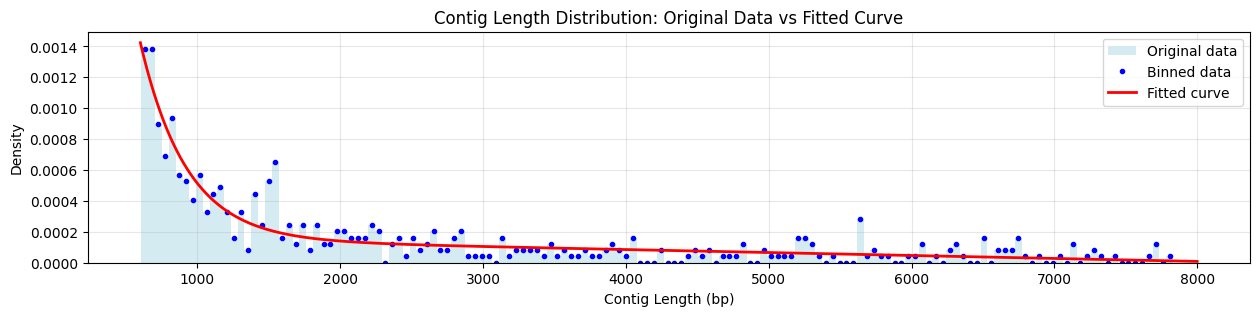


Created sampling dictionary with 7401 length-probability pairs


In [4]:
# Step 1: Create histogram bins for the contig length data
bins = 150  # Number of bins for histogram
ydata, bin_edges = np.histogram(sample, bins=bins, density=True)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Bin centers
print("First 3 x-values (bin centers):", xdata[:3])
print("First 3 y-values (densities):", ydata[:3])

# Step 2: Define the fitting function
# Combines exponential decay with linear term for flexible modeling
def func2(x, a, b, c, d):
    """
    Fitting function: exponential + linear + constant
    Parameters:
    - a: amplitude of exponential decay
    - b: decay rate
    - c: linear coefficient  
    - d: constant offset
    """
    return a * np.exp(-b * x) + c*x + d

# Step 3: Fit the function to binned histogram data
print("\nFitting curve to data...")
p0 = [4, 0.002, -0.0001, 0.001]  # Initial parameter guess [a, b, c, d]
popt, pcov = curve_fit(func2, xdata, ydata, p0=p0, maxfev=10000)
print("Fitted parameters [a, b, c, d]:", popt)

# Step 4: Generate fitted curve over desired length range
# Focus on range 600-8000 bp which covers most relevant contig sizes
xfine = range(600, 8000+1)
y_fitted = func2(xfine, *popt)

print(f"\nGenerated fitted curve for range {min(xfine)}-{max(xfine)} bp")
print("First 3 fitted values:", y_fitted[:3])
print("Last 3 fitted values:", y_fitted[-3:])

# Step 5: Normalize to create proper probability distribution
print(f"\nBefore normalization - sum: {sum(y_fitted):.6f}")
y_fitted /= sum(y_fitted)  # Normalize so probabilities sum to 1.0
print(f"After normalization - sum: {sum(y_fitted):.6f}")
print("Normalized first 3 values:", y_fitted[:3])
print("Normalized last 3 values:", y_fitted[-3:])

# Step 6: Visualize the original data and fitted curve
plt.figure(figsize=(15, 3))

# Plot original histogram
plt.hist(sample, bins=bins, density=True, alpha=0.5, label='Original data', color='lightblue')

# Plot binned data points
plt.plot(xdata, ydata, 'bo', markersize=3, label='Binned data')

# Plot fitted curve
plt.plot(xfine, y_fitted, 'r-', linewidth=2, label='Fitted curve')

plt.xlabel('Contig Length (bp)')
plt.ylabel('Density')
plt.title('Contig Length Distribution: Original Data vs Fitted Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 7: Create dictionary for sampling weights
# This maps each length (600-8000) to its probability for weighted sampling
xy_dict = dict(zip(xfine, y_fitted))
print(f"\nCreated sampling dictionary with {len(xy_dict)} length-probability pairs")

### 3.1 Detailed Visualization of Fitted Curve

Create a cleaner plot focusing on the fitted probability distribution curve.

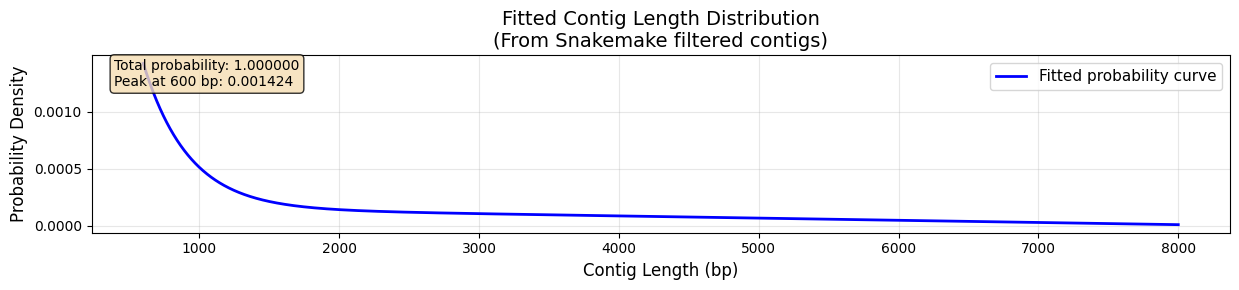

Distribution summary:
  Length range: 600 - 8000 bp
  Peak probability at: 600 bp
  Total probability mass: 1.000000


In [5]:
# Create a detailed plot of the fitted probability distribution
# This shows the clean fitted curve that will be used for sampling

fig, ax = plt.subplots(figsize=(12.5, 3))

# Plot the fitted curve from our probability dictionary
ax.plot(list(xy_dict.keys()), list(xy_dict.values()), 
        'b-', linewidth=2, label='Fitted probability curve')

# Formatting and labels
plt.xlabel('Contig Length (bp)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Fitted Contig Length Distribution\n(From Snakemake filtered contigs)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add some statistics as text
total_prob = sum(xy_dict.values())
max_prob_length = max(xy_dict, key=xy_dict.get)
max_prob_value = xy_dict[max_prob_length]

plt.text(0.02, 0.98, f'Total probability: {total_prob:.6f}\nPeak at {max_prob_length} bp: {max_prob_value:.6f}', 
         transform=ax.transAxes, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.show()

print(f"Distribution summary:")
print(f"  Length range: {min(xy_dict.keys())} - {max(xy_dict.keys())} bp")
print(f"  Peak probability at: {max_prob_length} bp")
print(f"  Total probability mass: {total_prob:.6f}")

## 4. Export Results

Save the fitted probability distribution for use in downstream sampling processes.

In [7]:
# Create output directory for sampling results
os.makedirs('results/training/sampling', exist_ok=True)

# Save the fitted probability distribution as JSON
# This dictionary maps contig lengths (600-8000 bp) to their sampling probabilities
# The downstream sampling script will use this for weighted random sampling
output_file = 'results/training/sampling/fitted_curve_lens_freq.json'

# Uncomment the line below to save the distribution
# mpu.io.write(output_file, xy_dict)

print(f"Fitted distribution ready to save to: {output_file}")
print(f"Dictionary contains {len(xy_dict)} length-probability pairs")
print(f"Length range: {min(xy_dict.keys())} - {max(xy_dict.keys())} bp")
print(f"Probability sum: {sum(xy_dict.values()):.6f}")

Fitted distribution ready to save to: results/training/sampling/fitted_curve_lens_freq.json
Dictionary contains 7401 length-probability pairs
Length range: 600 - 8000 bp
Probability sum: 1.000000


## 5. Validation: Post-Sampling Analysis

### Quality Check After Reference Genome Sampling

This section compares the original fitted curve (used for sampling) with the actual length distribution of sampled reference contigs. This validation step ensures that our sampling process successfully reproduces the target distribution.

**Process:**
1. Load contigs sampled by `00_sample_refs.py` 
2. Fit a new curve to the sampled contig lengths
3. Compare original vs. post-sampling distributions
4. Assess sampling quality and distribution preservation

In [8]:
# Alternative: Load previously saved fitted distribution
# Uncomment if you want to load the distribution from a saved JSON file
# xy_dict = mpu.io.read('../results/training/sampling/fitted_curve_lens_freq.json')
print("Using fitted distribution from current session (xy_dict)")

Using fitted distribution from current session (xy_dict)


In [9]:
# Load sampled reference contigs for validation
# These contigs were generated by the sampling script using our fitted distribution

print("Loading sampled reference contigs...")

# Path to sampled contigs (update path as needed)
# sampled_contigs = SeqIO.to_dict(SeqIO.parse('/home/tobamo/analize/model-tobamo/notebooks/MODEL4/results/training/sampling/2025-06-11_sampled_contigs_30.fasta', "fasta"))

sampled_path = '/home/tobamo/analize/project-tobamo/analysis/model/results/training/sampling/2025-07-11_sampled_contigs_30.fasta'
sampled_contigs = SeqIO.to_dict(SeqIO.parse(sampled_path, "fasta"))

print(f"Loaded {len(sampled_contigs)} sampled contigs from:")
print(f"  {sampled_path}")

# Extract contig information for analysis
df_sampled = pd.DataFrame({
    'contig_name': list(sampled_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in sampled_contigs.values()]
})

# Create list of sampled contig lengths for comparison
new_sample = df_sampled['contig_length'].to_list()

# Display statistics for sampled contigs
print(f"\nSampled contig statistics:")
print(f"  Count: {len(new_sample)}")
print(f"  Min length: {min(new_sample)} bp")
print(f"  Max length: {max(new_sample)} bp")
print(f"  Mean length: {np.mean(new_sample):.1f} bp")
print(f"  Median length: {np.median(new_sample):.1f} bp")

Loading sampled reference contigs...
Loaded 3750 sampled contigs from:
  /home/tobamo/analize/project-tobamo/analysis/model/results/training/sampling/2025-07-11_sampled_contigs_30.fasta

Sampled contig statistics:
  Count: 3750
  Min length: 600 bp
  Max length: 7226 bp
  Mean length: 1957.1 bp
  Median length: 1277.0 bp


Fitting curve to sampled contig lengths...
Sample - First 3 x-values: [622.08666667 666.26       710.43333333]
Sample - First 3 y-values: [0.00153335 0.00120133 0.00108663]
Fitted parameters for sampled data [a, b, c, d]: [ 8.22447690e-03  3.00498794e-03 -2.52636656e-08  1.81752815e-04]
Sampled curve normalized sum: 1.000000


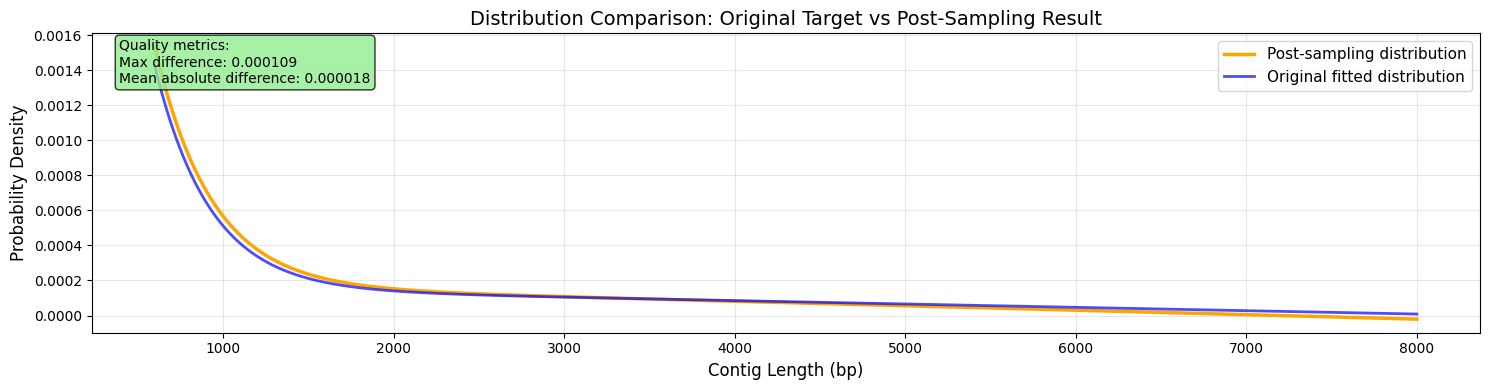


Distribution comparison:
  Original curve peak: 0.001424
  Sampled curve peak: 0.001533
  Maximum difference: 0.000109
  Mean absolute difference: 0.000018
✓ Excellent sampling quality - distributions closely match


In [10]:
# Fit curve to sampled contig length distribution for comparison

print("Fitting curve to sampled contig lengths...")

# Step 1: Create histogram of sampled contig lengths
bins = 150
ydata_sampled, bin_edges_sampled = np.histogram(new_sample, bins=bins, density=True)
xdata_sampled = 0.5 * (bin_edges_sampled[1:] + bin_edges_sampled[:-1])
print("Sample - First 3 x-values:", xdata_sampled[:3])
print("Sample - First 3 y-values:", ydata_sampled[:3])

# Step 2: Use same fitting function as before
def func2(x, a, b, c, d):
    """Same fitting function: a*exp(-b*x) + c*x + d"""
    return a * np.exp(-b * x) + c*x + d

# Step 3: Fit function to sampled data
# Use parameters from original fit as initial guess
p0 = [7.93139545e-03, 3.05621468e-03, -1.81668155e-08, 1.58731686e-04]
popt_sampled, pcov_sampled = curve_fit(func2, xdata_sampled, ydata_sampled, p0=p0, maxfev=10000)
print("Fitted parameters for sampled data [a, b, c, d]:", popt_sampled)

# Step 4: Generate fitted curve for comparison (same range as original)
xfine = range(600, 8000+1)
sample_y_fitted = func2(xfine, *popt_sampled)

# Step 5: Normalize sampled curve
sample_y_fitted /= sum(sample_y_fitted)

print(f"Sampled curve normalized sum: {sum(sample_y_fitted):.6f}")

# Step 6: Create comparison plot
plt.figure(figsize=(15, 4))

# Plot both fitted curves for comparison
plt.plot(xfine, sample_y_fitted, 'orange', linewidth=2.5, label='Post-sampling distribution')
plt.plot(xfine, y_fitted, 'blue', linewidth=2, alpha=0.7, label='Original fitted distribution')

# Formatting
plt.xlabel('Contig Length (bp)', fontsize=12)
plt.ylabel('Probability Density', fontsize=12)
plt.title('Distribution Comparison: Original Target vs Post-Sampling Result', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add difference statistics
diff_max = max(abs(sample_y_fitted - y_fitted))
diff_mean = np.mean(abs(sample_y_fitted - y_fitted))

plt.text(0.02, 0.98, f'Quality metrics:\nMax difference: {diff_max:.6f}\nMean absolute difference: {diff_mean:.6f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.show()

# Step 7: Print comparison statistics
print(f"\nDistribution comparison:")
print(f"  Original curve peak: {max(y_fitted):.6f}")
print(f"  Sampled curve peak: {max(sample_y_fitted):.6f}")
print(f"  Maximum difference: {diff_max:.6f}")
print(f"  Mean absolute difference: {diff_mean:.6f}")

if diff_mean < 0.0001:
    print("✓ Excellent sampling quality - distributions closely match")
elif diff_mean < 0.001:
    print("✓ Good sampling quality - minor differences")
else:
    print("⚠ Consider reviewing sampling parameters - larger differences detected")

In [11]:
# Save the post-sampling fitted distribution for reference

# Create dictionary from sampled distribution fit
xy_dict_sampled = dict(zip(xfine, sample_y_fitted))

# Save the sampled distribution parameters
output_file_sampled = 'results/training/sampling/fitted_curve_lens_freq_sampled.json'
mpu.io.write(output_file_sampled, xy_dict_sampled)

print(f"✓ Saved post-sampling distribution to: {output_file_sampled}")
print(f"  Contains {len(xy_dict_sampled)} length-probability pairs")
print(f"  Probability sum: {sum(xy_dict_sampled.values()):.6f}")

# Summary of all outputs
print(f"\n" + "="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"Original contigs analyzed: {len(sample)}")
print(f"Sampled contigs validated: {len(new_sample)}")
print(f"Length range modeled: {min(xfine)} - {max(xfine)} bp")
print(f"Sampling quality (mean abs diff): {np.mean(abs(sample_y_fitted - y_fitted)):.6f}")
print(f"\nOutput files:")
print(f"  • fitted_curve_lens_freq.json (for sampling)")
print(f"  • fitted_curve_lens_freq_sampled.json (validation)")
print("="*60)

✓ Saved post-sampling distribution to: results/training/sampling/fitted_curve_lens_freq_sampled.json
  Contains 7401 length-probability pairs
  Probability sum: 1.000000

ANALYSIS SUMMARY
Original contigs analyzed: 510
Sampled contigs validated: 3750
Length range modeled: 600 - 8000 bp
Sampling quality (mean abs diff): 0.000018

Output files:
  • fitted_curve_lens_freq.json (for sampling)
  • fitted_curve_lens_freq_sampled.json (validation)
